In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer,  AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
import pandas as pd
import numpy as np

/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the main dataset
file_path = "dataset.tsv"
df = pd.read_csv(file_path, sep='\t')

In [8]:
# See examples from the dataset
df

,Comment,Score,Link,Brand,Type
0,ürün güzel ve sağlam ulaştı..1 yıldız kırma se...,4,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
1,kaliteli hızlı kargo ve teslimat,5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
2,"Ürün gayeten güzel, paketleme siz çok iyiydi.",5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
3,Cok guzeeeel,4,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
4,Ürünüm koşa sürede hasarsız ulaştı kırık yoktu...,5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
...,...,...,...,...,...
40445,Bugün kurulumu oldu daha kullanmadım ama profi...,5,https://www.trendyol.com/profilo/km961rctr-9-k...,profilo,Dryer
40446,Servis ürünü kurmaya geldi ürünü açtı ürün kır...,1,https://www.trendyol.com/profilo/km961rctr-9-k...,profilo,Dryer
40447,profilodan şaşmam. kurutmasini deneyip göreceğ...,5,https://www.trendyol.com/profilo/km961rctr-9-k...,profilo,Dryer
40448,lütfen insanları mağdur etmemek için borusan l...,2,https://www.trendyol.com/profilo/km961rctr-9-k...,profilo,Dryer


In [9]:
# See brand and type counts
len(set(df['Brand'])), len(set(df['Type']))

(415, 77)

In [10]:
# See the types
set(df['Type'])

{'Air conditioner',
 'Air humidifier',
 'Appliance spare parts',
 'Aspirator',
 'Beverage preparation',
 'Bluetooth headphones',
 'Boiler',
 'Charger',
 'Coffee maker',
 'Computer',
 'Computer components',
 'Computer games',
 'Computer spare parts',
 'Computer tablet accessories',
 'Console accessories',
 'Data storage',
 'Dishwasher',
 'Dryer',
 'Electronic trousseau set',
 'Epilator',
 'Fan',
 'Food preparation',
 'Freezer',
 'Game consoles',
 'Gaming computer',
 'Gaming headphones',
 'Hair dryer',
 'Hair straightener',
 'Hairdressing table',
 'Heater',
 'Home theater system',
 'Hoods',
 'In-ear headphones',
 'Instant water heater',
 'Ipl laser hair removal devices',
 'Iron',
 'Joystick',
 'Keyboard',
 'Laptop',
 'Laser printer',
 'Microwave oven',
 'Mini Refrigerator',
 'Mini midi oven',
 'Mobile phone',
 'Monitor',
 'Mouse',
 'Music system',
 'On-ear headphones',
 'Other electric cookers',
 'Oven',
 'Over-ear bluetooth headphones',
 'Phone accessories',
 'Playstation consoles',
 'P

<Axes: ylabel='count'>

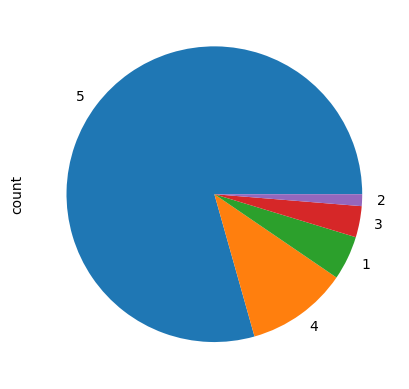

In [3]:
# Check the score distribution
df['Score'].value_counts().plot.pie()

In [4]:
# Perform experimental undersampling
df = df.drop(df[df['Score'] == 5].sample(frac=.9).index)
df = df.drop(df[df['Score'] == 4].sample(frac=.5).index)

<Axes: ylabel='count'>

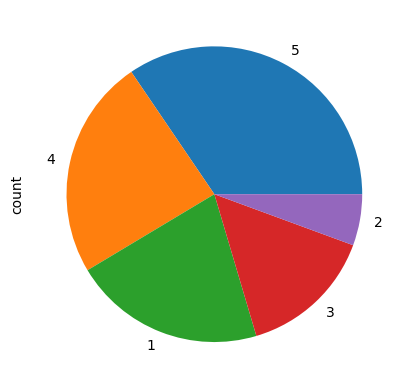

In [5]:
# Re-check the score distribution
df['Score'].value_counts().plot.pie()

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["Comment"], df['Score'], test_size=0.2, random_state=42)

In [19]:
df.head()

,Comment,Score,Link,Brand,Type
1,kaliteli hızlı kargo ve teslimat,5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
3,Cok guzeeeel,4,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
8,Televizyon ekranı yarısı komple kırık bir şeki...,1,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
12,10 numara cok iyi,5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
13,kaliteli Güzel,5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television


In [7]:
# We can see that the dataset is undersampled drastically
df.describe()

,Score
count,9308.000000
mean,3.454985
std,1.519832
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [8]:
# For more information, please check this link: https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [9]:
# Check classes and their weights
np.unique(y_train)

array([1, 2, 3, 4, 5])

In [10]:
class_weights

array([0.95706941, 3.51226415, 1.35505005, 0.82871452, 0.57945525])

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification

# Load pre-trained Turkish BERT model and tokenizer
model_name = 'dbmdz/distilbert-base-turkish-cased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=5)

# We used the following lines  to freeze some of the parameters but it did not work well

#for name, param in model.named_parameters():
#    if "classifier" not in name:
#        param.requires_grad = False
#    else:
#        param.requires_grad = True

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Tokenize the input data
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors='pt', max_length=512)
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors='pt', max_length=512)

In [13]:
# Create the dataset and DataLoader for training and testing sets
class ReviewDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

from torch.utils.data import DataLoader

train_dataset = ReviewDataset(X_train_tokens, y_train)
test_dataset = ReviewDataset(X_test_tokens, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Set up training parameters, these parameters are pretty standard for BERT models
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=5e-6)
epochs = 3

# Training loop, define our loss function and finetune the model
device = torch.device('mps')
model.to(device)
criterion = nn.CrossEntropyLoss().to(device) #

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = (batch['labels'] - 1).to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [04:46<00:00,  1.23s/it]


Epoch 1/3, Loss: 1.2050476662590779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [04:46<00:00,  1.23s/it]


Epoch 2/3, Loss: 0.9989255963476942


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [04:46<00:00,  1.23s/it]

Epoch 3/3, Loss: 0.9014377293412777


In [15]:
# Evaluate our model on the test set after training
model.eval()
all_predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = (batch['labels'] - 1).to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy() + 1)
        true_labels.extend(labels.cpu().numpy() + 1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:09<00:00,  6.27it/s]


**Here, you can see some of the experiments that we ran. Nonetheless, we could not acquire a nice result compared to other baselines.**

```
Zero Addition

Precision: 0.47874842353527436
Recall: 0.6177062374245473
F1 Score: 0.5225779740886669
Accuracy: 0.6177062374245473

Undersample 4000 Positive Examples

Precision: 0.45119181230292343
Recall: 0.5050505050505051
F1 Score: 0.4584380937185949
Accuracy: 0.5050505050505051

New Full Dataset - DistilBert

Precision: 0.6730893493009384
Recall: 0.5914709517923362
F1 Score: 0.6181233191269568
Accuracy: 0.5914709517923362

New Full Dataset - Sampled - DistilBert

Precision: 0.5874430440605886
Recall: 0.5821697099892589
F1 Score: 0.5817278030173941
Accuracy: 0.5821697099892589

New Full Dataset - Sampled - No Class Weights

Precision: 0.5533514300057746
Recall: 0.5918367346938775
F1 Score: 0.5692876208664942
Accuracy: 0.5918367346938775
```

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate precision, recall, and F1 score
report = classification_report(true_labels, all_predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

# Display the classification report and confusion matrix
# Note: Actually, BERT model has better averaged precision, recall, and F1 scores
#       But the overall accuracy is significantly lower than the baselines
print("\nClassification Report:\n", classification_report(true_labels, all_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(true_labels, all_predictions))
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy_score(true_labels, all_predictions))


Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.87      0.77       398
           2       0.00      0.00      0.00        98
           3       0.36      0.42      0.39       279
           4       0.45      0.37      0.41       446
           5       0.71      0.73      0.72       641

    accuracy                           0.59      1862
   macro avg       0.44      0.48      0.46      1862
weighted avg       0.55      0.59      0.57      1862


Confusion Matrix:
 [[347   0  45   3   3]
 [ 67   0  22   5   4]
 [ 60   0 117  69  33]
 [ 15   0 111 167 153]
 [ 12   0  27 131 471]]

Precision: 0.5533514300057746
Recall: 0.5918367346938775
F1 Score: 0.5692876208664942
Accuracy: 0.5918367346938775


/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

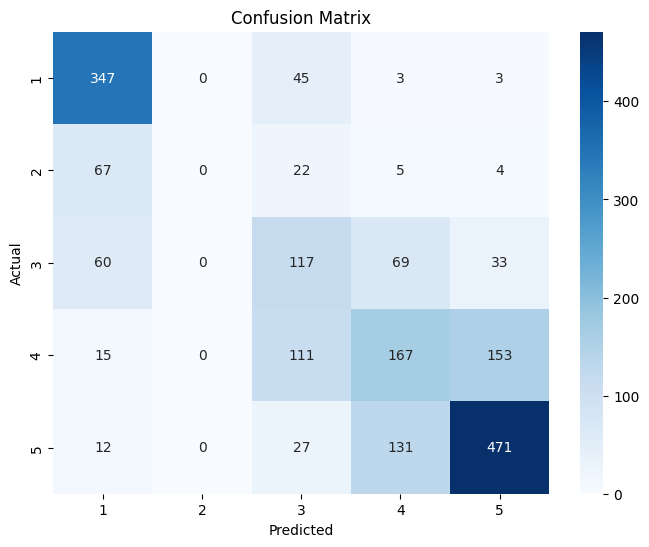

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(true_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['Score'].unique()), yticklabels=sorted(df['Score'].unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

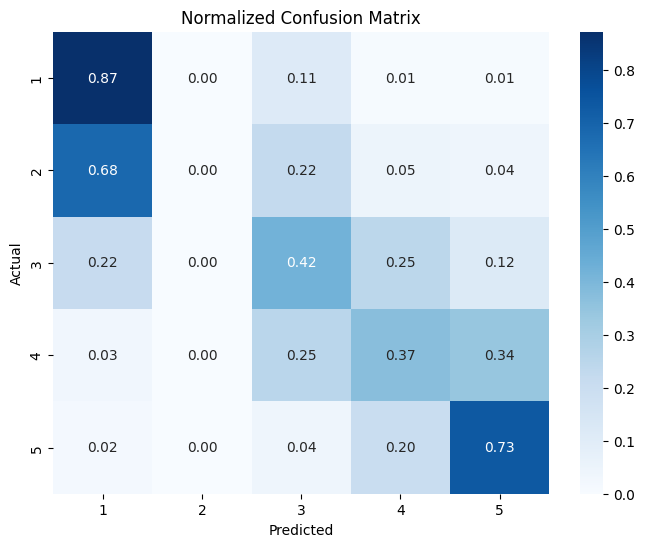

In [18]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, all_predictions)

# Normalize the confusion matrix to analyze smaller classes better
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=sorted(df['Score'].unique()), yticklabels=sorted(df['Score'].unique()))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()